In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import cv2
import random
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
from tqdm.notebook import tqdm
import time

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_dir = '/content/drive/MyDrive/PCD/FishImgDataset/train'
val_dir = '/content/drive/MyDrive/PCD/FishImgDataset/val'
test_dir = '/content/drive/MyDrive/PCD/FishImgDataset/test'

In [4]:
# Check class folders in the train dataset
classes = os.listdir(train_dir)
print(f"Classes: {classes}")

Classes: ['Bangus', 'barrel_jellyfish', 'Corals', 'compass_jellyfish', 'Climbing Perch', 'Clams', 'Dolphin', 'blue_jellyfish', 'Crabs', 'Catfish', 'Black Spotted Barb', 'Big Head Carp', 'Fourfinger Threadfin', 'Goby', 'Gold Fish', 'Indo-Pacific Tarpon', 'Indian Carp', 'Green Spotted Puffer', 'Freshwater Eel', 'Grass Carp', 'Gourami', 'Glass Perchlet', 'Jaguar Gapote', 'Mosquito Fish', 'mauve_stinger_jellyfish', 'Janitor Fish', 'Moon_jellyfish', 'lions_mane_jellyfish', 'Knifefish', 'Mudfish', 'Lobster', 'Long-Snouted Pipefish', 'Mullet', 'Nudibranchs', 'Puffers', 'Otter', 'Scat Fish', 'Perch', 'Pangasius', 'Penguin', 'Sea Rays', 'Octopus', 'Tenpounder', 'Silver Barb', 'Snakehead', 'Silver Perch', 'Silver Carp', 'Tilapia']


Classes: ['Bangus', 'barrel_jellyfish', 'Corals', 'compass_jellyfish', 'Climbing Perch', 'Clams', 'Dolphin', 'blue_jellyfish', 'Crabs', 'Catfish', 'Black Spotted Barb', 'Big Head Carp', 'Fourfinger Threadfin', 'Goby', 'Gold Fish', 'Indo-Pacific Tarpon', 'Indian Carp', 'Green Spotted Puffer', 'Freshwater Eel', 'Grass Carp', 'Gourami', 'Glass Perchlet', 'Jaguar Gapote', 'Mosquito Fish', 'mauve_stinger_jellyfish', 'Janitor Fish', 'Moon_jellyfish', 'lions_mane_jellyfish', 'Knifefish', 'Mudfish', 'Lobster', 'Long-Snouted Pipefish', 'Mullet', 'Nudibranchs', 'Puffers', 'Otter', 'Scat Fish', 'Perch', 'Pangasius', 'Penguin', 'Sea Rays', 'Octopus', 'Tenpounder', 'Silver Barb', 'Snakehead', 'Silver Perch', 'Silver Carp', 'Tilapia']

Train Dataset Image Counts:
                      Class  Image_Count
19               Grass Carp         1212
13                     Goby          607
6                   Dolphin          546
21           Glass Perchlet          399
41                  Octopus        

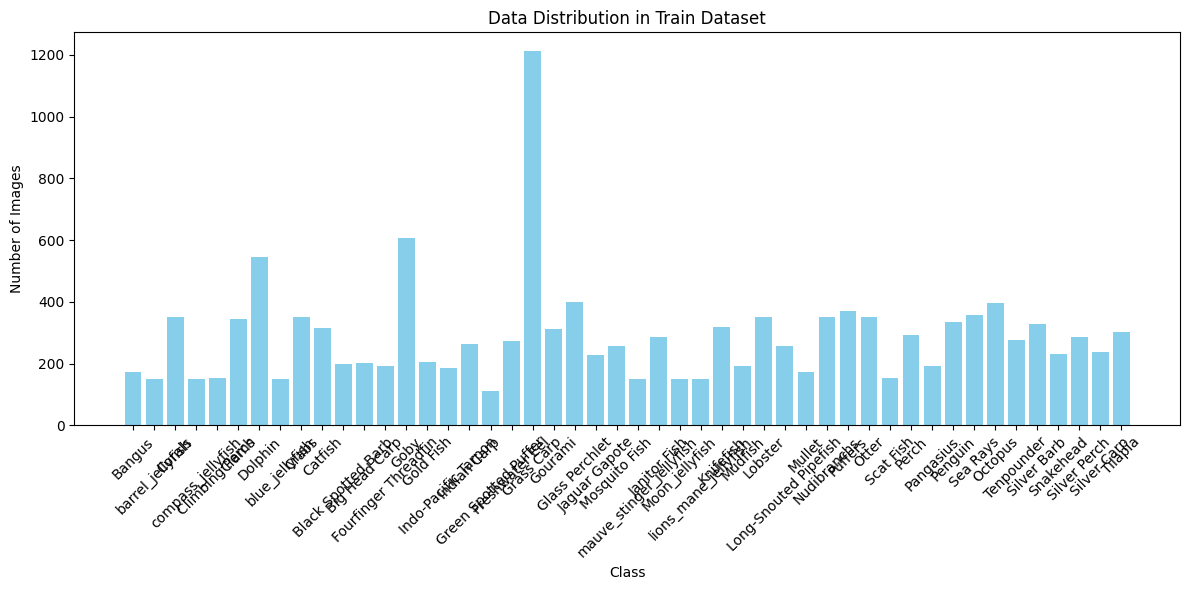

In [5]:
def count_images_in_folders(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Check class folders and display counts
classes = os.listdir(train_dir)
print(f"Classes: {classes}")

# Count images per class
train_counts = count_images_in_folders(train_dir)
val_counts = count_images_in_folders(val_dir)
test_counts = count_images_in_folders(test_dir)

# Convert counts to DataFrames
train_df = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Image_Count'])
val_df = pd.DataFrame(list(val_counts.items()), columns=['Class', 'Image_Count'])
test_df = pd.DataFrame(list(test_counts.items()), columns=['Class', 'Image_Count'])

# Display the counts
print("\nTrain Dataset Image Counts:")
print(train_df.sort_values(by='Image_Count', ascending=False))
print("\nValidation Dataset Image Counts:")
print(val_df.sort_values(by='Image_Count', ascending=False))
print("\nTest Dataset Image Counts:")
print(test_df.sort_values(by='Image_Count', ascending=False))

# Plot data distribution
plt.figure(figsize=(12, 6))
plt.bar(train_df['Class'], train_df['Image_Count'], color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Data Distribution in Train Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

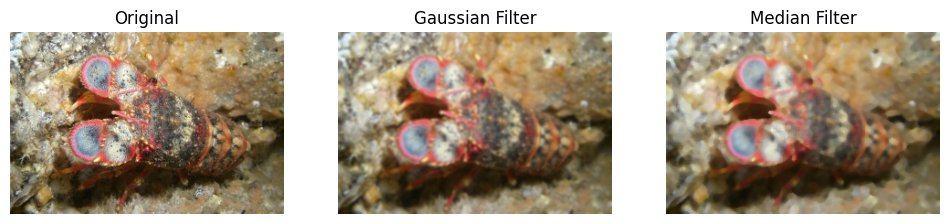

In [6]:
def apply_noise_reduction(image_path):
    # Read image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply Gaussian filter
    gaussian = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply Median filter
    median = cv2.medianBlur(img, 5)

    return gaussian, median

def display_filters(image_path):
    img = Image.open(image_path)
    gaussian, median = apply_noise_reduction(image_path)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Gaussian Filter")
    plt.imshow(gaussian)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Median Filter")
    plt.imshow(median)
    plt.axis('off')

    plt.show()

# Display example of filters
random_class = random.choice(os.listdir(train_dir))
random_image_path = os.path.join(train_dir, random_class,
                                random.choice(os.listdir(os.path.join(train_dir, random_class))))
display_filters(random_image_path)


Class: Gold Fish


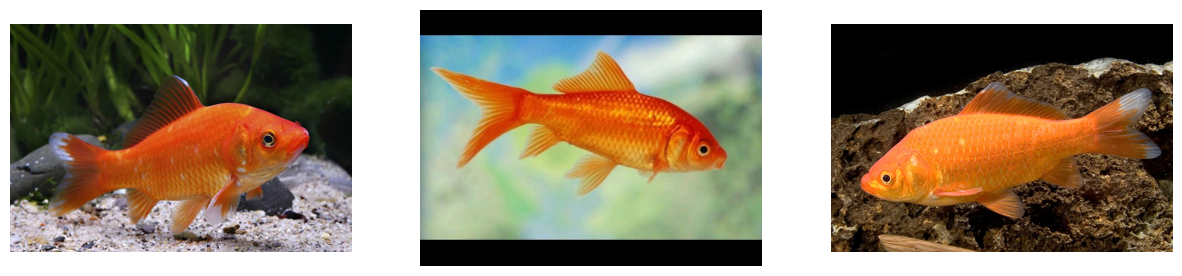


Class: Big Head Carp


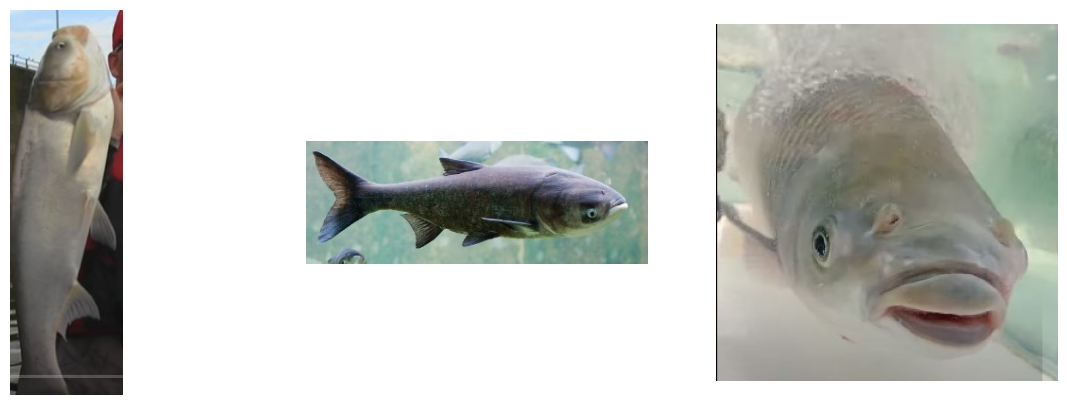


Class: Clams


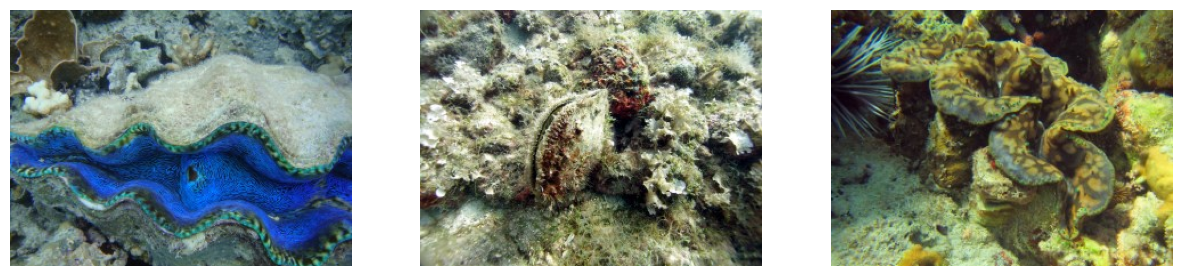


Class: Climbing Perch


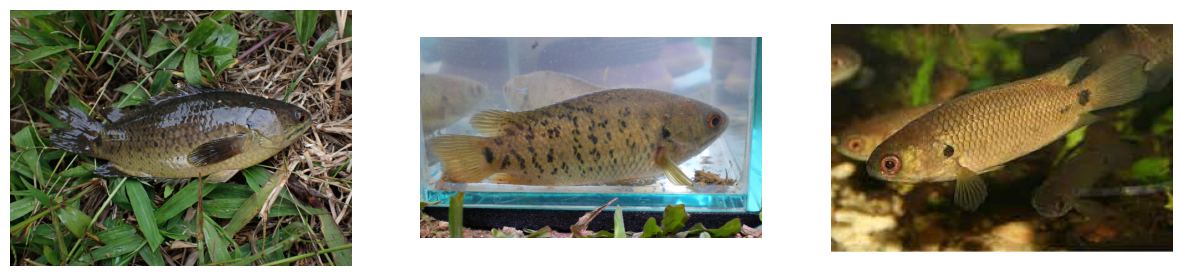


Class: Penguin


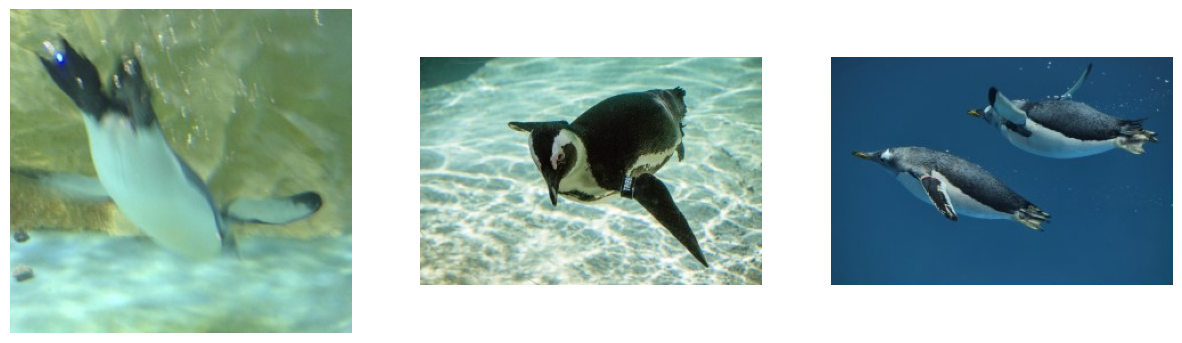

In [7]:
# Display sample images from random classes
def show_sample_images(dataset_dir, classes, num_samples=3):
    for class_name in random.sample(classes, min(len(classes), 5)):
        class_path = os.path.join(dataset_dir, class_name)
        image_files = os.listdir(class_path)
        print(f"\nClass: {class_name}")
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
        for i, ax in enumerate(axes):
            img_path = os.path.join(class_path, random.choice(image_files))
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')
        plt.show()

show_sample_images(train_dir, classes)

In [8]:
# Function for histogram equalization
def apply_histogram_equalization(image_path):
    img = cv2.imread(image_path, 0)  # Grayscale image
    equalized = cv2.equalizeHist(img)
    return equalized

# Function for contrast stretching
def apply_contrast_stretching(image_path):
    img = cv2.imread(image_path, 0)  # Grayscale image
    p2, p98 = np.percentile(img, (2, 98))  # 2nd and 98th percentiles
    stretched = cv2.normalize(img, None, alpha=p2, beta=p98, norm_type=cv2.NORM_MINMAX)
    return stretched

# Display the enhanced images
def display_enhancements(image_path):
    original = Image.open(image_path).convert("L")
    equalized = apply_histogram_equalization(image_path)
    stretched = apply_contrast_stretching(image_path)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(original, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Histogram Equalization")
    plt.imshow(equalized, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Contrast Stretching")
    plt.imshow(stretched, cmap="gray")
    plt.axis('off')

    plt.show()

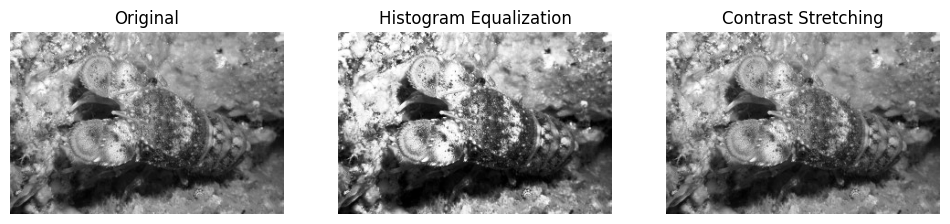

In [9]:
# Example usage: Enhance a random image from the dataset
display_enhancements(random_image_path)

In [10]:
class FishDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.classes = sorted(os.listdir(image_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for cls in self.classes:
            class_dir = os.path.join(image_dir, cls)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[cls])

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img, label
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            return torch.zeros((3, 224, 224)), label

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = FishDataset(train_dir, transform=transform)
val_dataset = FishDataset(val_dir, transform=transform)
test_dataset = FishDataset(test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [11]:
def create_model(num_classes):
    # Use ResNet50 with latest weights
    weights = models.ResNet50_Weights.DEFAULT
    model = models.resnet50(weights=weights)

    # Freeze early layers
    for param in list(model.parameters())[:-2]:
        param.requires_grad = False

    # Modify the final layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    val_losses = []
    best_val_acc = 0.0

    # For plotting
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_pbar = tqdm(train_loader, desc='Training')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update progress bar
            train_pbar.set_postfix({
                'loss': running_loss/total,
                'acc': 100.*correct/total
            })

        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        val_pbar = tqdm(val_loader, desc='Validation')
        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Update progress bar
                val_pbar.set_postfix({
                    'loss': val_loss/total,
                    'acc': 100.*correct/total
                })

        val_acc = 100. * correct / total
        val_loss = val_loss / len(val_loader)

        # Store the losses and accuracies
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        epoch_end = time.time()

        print(f'\nEpoch Summary:')
        print(f'Time: {(epoch_end-epoch_start)/60:.2f} minutes')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'New best model saved with validation accuracy: {val_acc:.2f}%')

        # Plot training progress
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title('Loss Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Acc')
        plt.plot(history['val_acc'], label='Val Acc')
        plt.title('Accuracy Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return train_losses, val_losses

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]



Epoch 1/10
--------------------------------------------------


Training:   0%|          | 0/431 [00:00<?, ?it/s]

Validation:   0%|          | 0/115 [00:00<?, ?it/s]


Epoch Summary:
Time: 17.30 minutes
Train Loss: 1.6478, Train Acc: 63.34%
Val Loss: 0.9819, Val Acc: 77.95%
New best model saved with validation accuracy: 77.95%


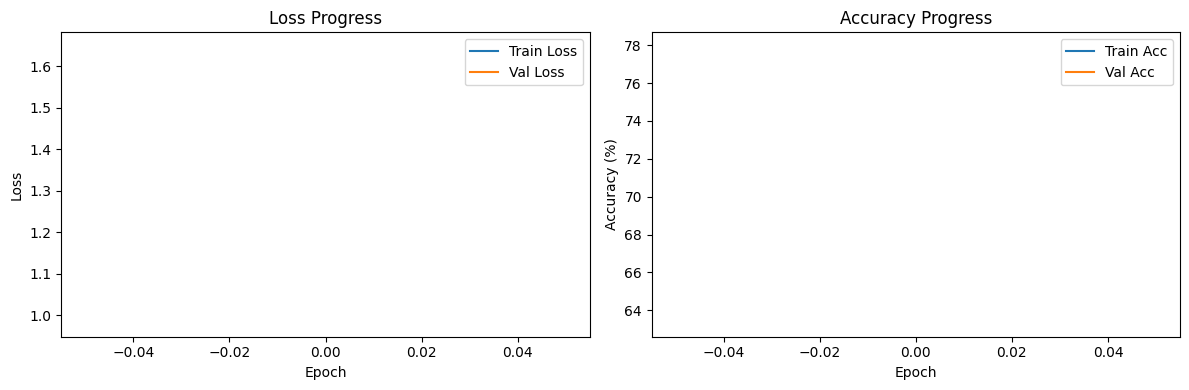


Epoch 2/10
--------------------------------------------------


Training:   0%|          | 0/431 [00:00<?, ?it/s]

Validation:   0%|          | 0/115 [00:00<?, ?it/s]


Epoch Summary:
Time: 1.90 minutes
Train Loss: 0.7591, Train Acc: 82.41%
Val Loss: 0.6990, Val Acc: 83.62%
New best model saved with validation accuracy: 83.62%


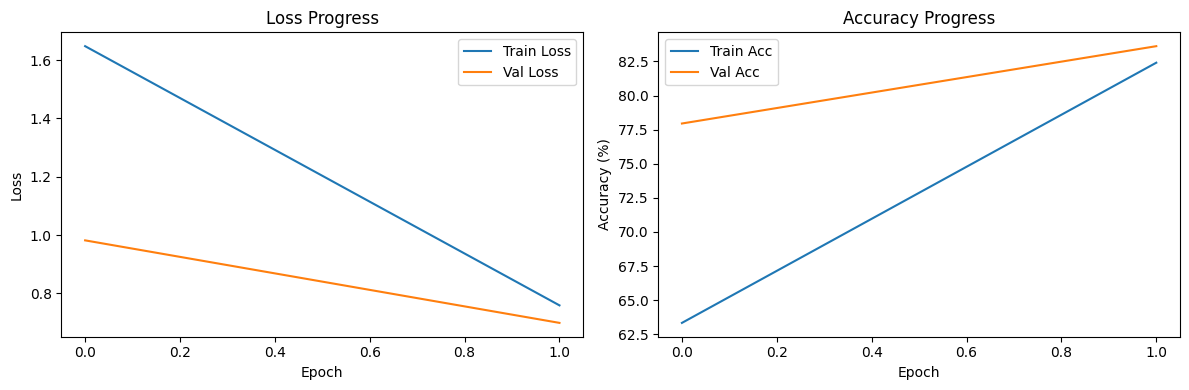


Epoch 3/10
--------------------------------------------------


Training:   0%|          | 0/431 [00:00<?, ?it/s]

Validation:   0%|          | 0/115 [00:00<?, ?it/s]


Epoch Summary:
Time: 1.91 minutes
Train Loss: 0.5655, Train Acc: 86.92%
Val Loss: 0.5631, Val Acc: 87.33%
New best model saved with validation accuracy: 87.33%


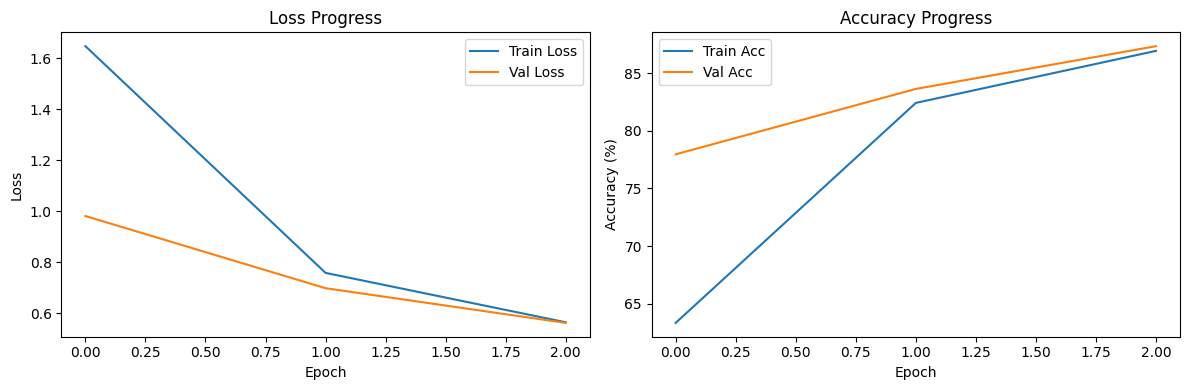


Epoch 4/10
--------------------------------------------------


Training:   0%|          | 0/431 [00:00<?, ?it/s]

Validation:   0%|          | 0/115 [00:00<?, ?it/s]


Epoch Summary:
Time: 1.93 minutes
Train Loss: 0.4589, Train Acc: 88.77%
Val Loss: 0.5114, Val Acc: 87.74%
New best model saved with validation accuracy: 87.74%


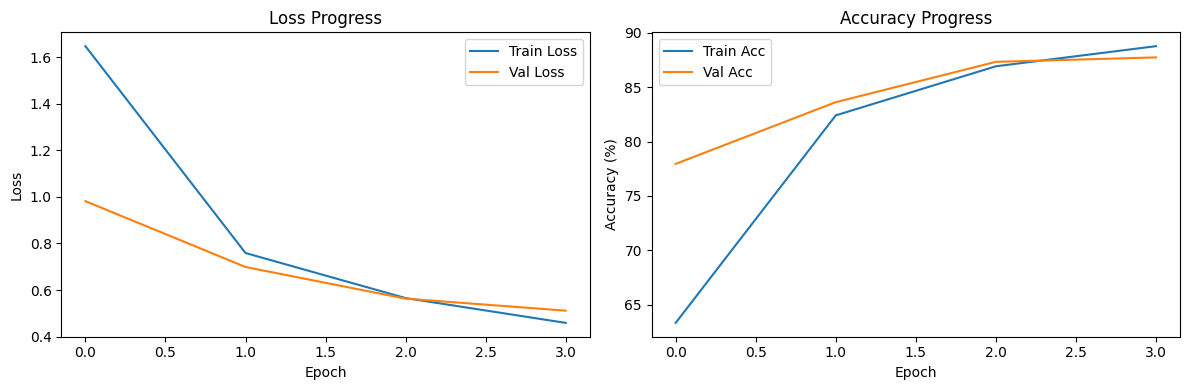


Epoch 5/10
--------------------------------------------------


Training:   0%|          | 0/431 [00:00<?, ?it/s]

Validation:   0%|          | 0/115 [00:00<?, ?it/s]


Epoch Summary:
Time: 1.92 minutes
Train Loss: 0.3932, Train Acc: 90.43%
Val Loss: 0.4636, Val Acc: 89.02%
New best model saved with validation accuracy: 89.02%


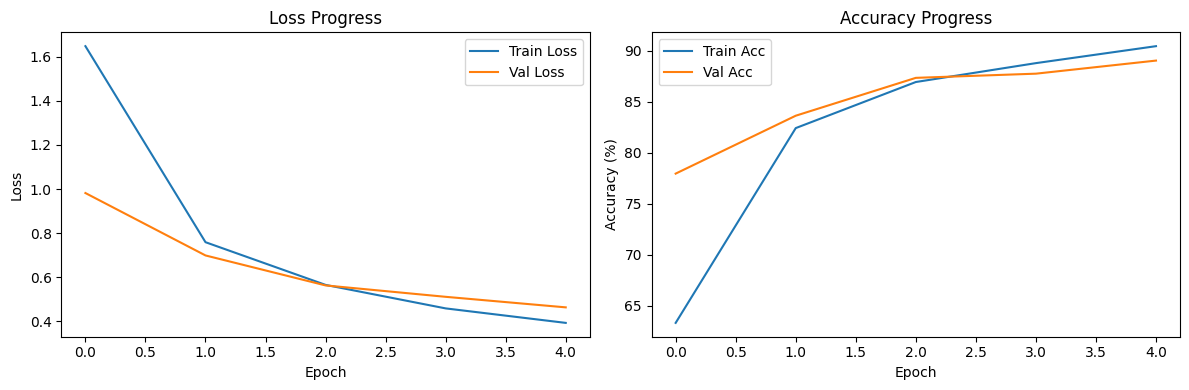


Epoch 6/10
--------------------------------------------------


Training:   0%|          | 0/431 [00:00<?, ?it/s]

Validation:   0%|          | 0/115 [00:00<?, ?it/s]


Epoch Summary:
Time: 1.90 minutes
Train Loss: 0.3430, Train Acc: 91.79%
Val Loss: 0.4292, Val Acc: 89.67%
New best model saved with validation accuracy: 89.67%


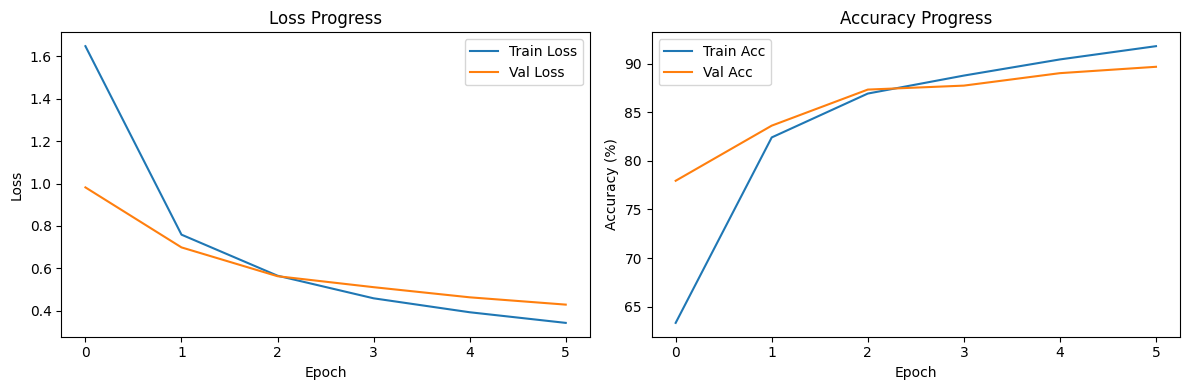


Epoch 7/10
--------------------------------------------------


Training:   0%|          | 0/431 [00:00<?, ?it/s]

Validation:   0%|          | 0/115 [00:00<?, ?it/s]


Epoch Summary:
Time: 1.91 minutes
Train Loss: 0.3124, Train Acc: 92.24%
Val Loss: 0.4168, Val Acc: 89.13%


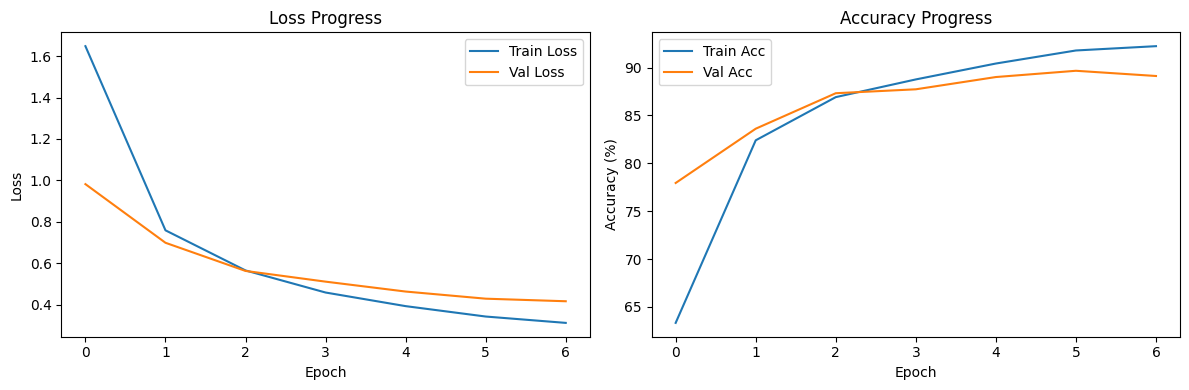


Epoch 8/10
--------------------------------------------------


Training:   0%|          | 0/431 [00:00<?, ?it/s]

Validation:   0%|          | 0/115 [00:00<?, ?it/s]


Epoch Summary:
Time: 1.92 minutes
Train Loss: 0.2819, Train Acc: 92.84%
Val Loss: 0.3923, Val Acc: 90.08%
New best model saved with validation accuracy: 90.08%


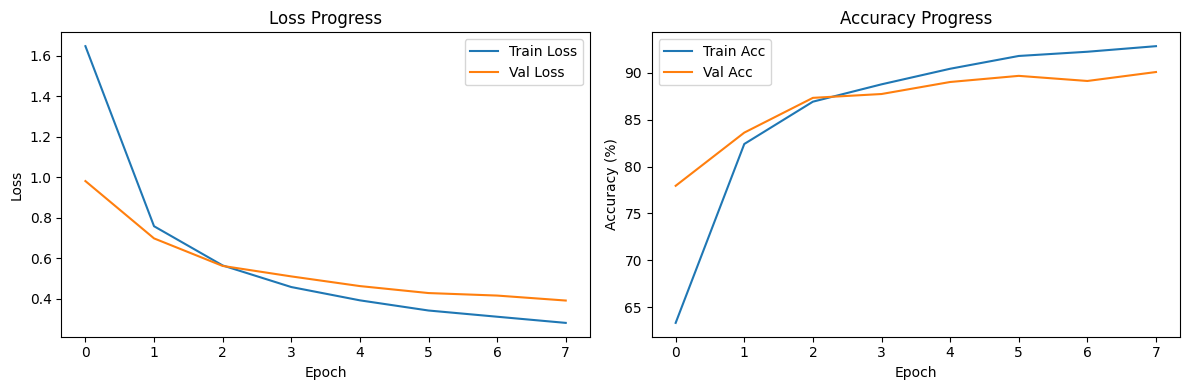


Epoch 9/10
--------------------------------------------------


Training:   0%|          | 0/431 [00:00<?, ?it/s]

Validation:   0%|          | 0/115 [00:00<?, ?it/s]


Epoch Summary:
Time: 1.93 minutes
Train Loss: 0.2563, Train Acc: 93.51%
Val Loss: 0.3895, Val Acc: 90.62%
New best model saved with validation accuracy: 90.62%


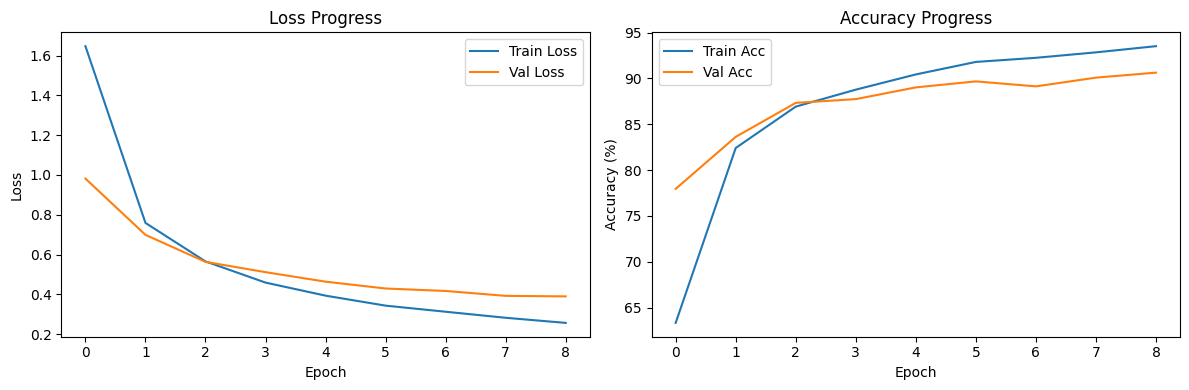


Epoch 10/10
--------------------------------------------------


Training:   0%|          | 0/431 [00:00<?, ?it/s]

Validation:   0%|          | 0/115 [00:00<?, ?it/s]


Epoch Summary:
Time: 1.91 minutes
Train Loss: 0.2351, Train Acc: 94.31%
Val Loss: 0.3553, Val Acc: 91.63%
New best model saved with validation accuracy: 91.63%


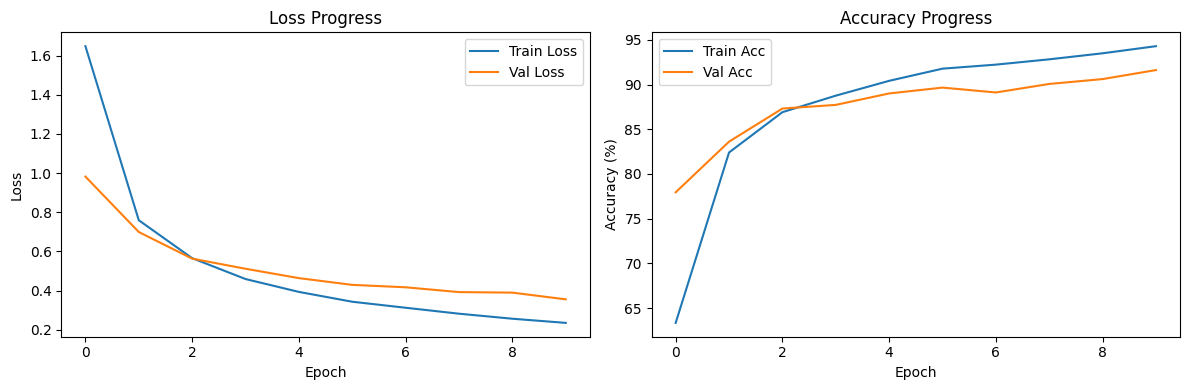

In [13]:
# Create and train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = create_model(num_classes=len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10
)

In [14]:
# Save the final model
torch.save(model.state_dict(), 'resnet_fish_model.pth')
print("Model saved successfully!")

Model saved successfully!


Testing Performance:
                         precision    recall  f1-score   support

                 Bangus       0.79      1.00      0.88        34
          Big Head Carp       0.95      0.95      0.95        43
     Black Spotted Barb       0.95      0.88      0.91        40
                Catfish       0.95      0.94      0.94        62
                  Clams       0.67      0.70      0.68        77
         Climbing Perch       0.81      0.87      0.84        30
                 Corals       0.76      0.69      0.73        75
                  Crabs       0.92      0.99      0.95        77
                Dolphin       0.97      0.88      0.93       119
   Fourfinger Threadfin       1.00      0.89      0.94        38
         Freshwater Eel       0.92      0.89      0.91        55
         Glass Perchlet       0.96      0.94      0.95        77
                   Goby       0.90      0.95      0.93       124
              Gold Fish       0.98      1.00      0.99        41
   

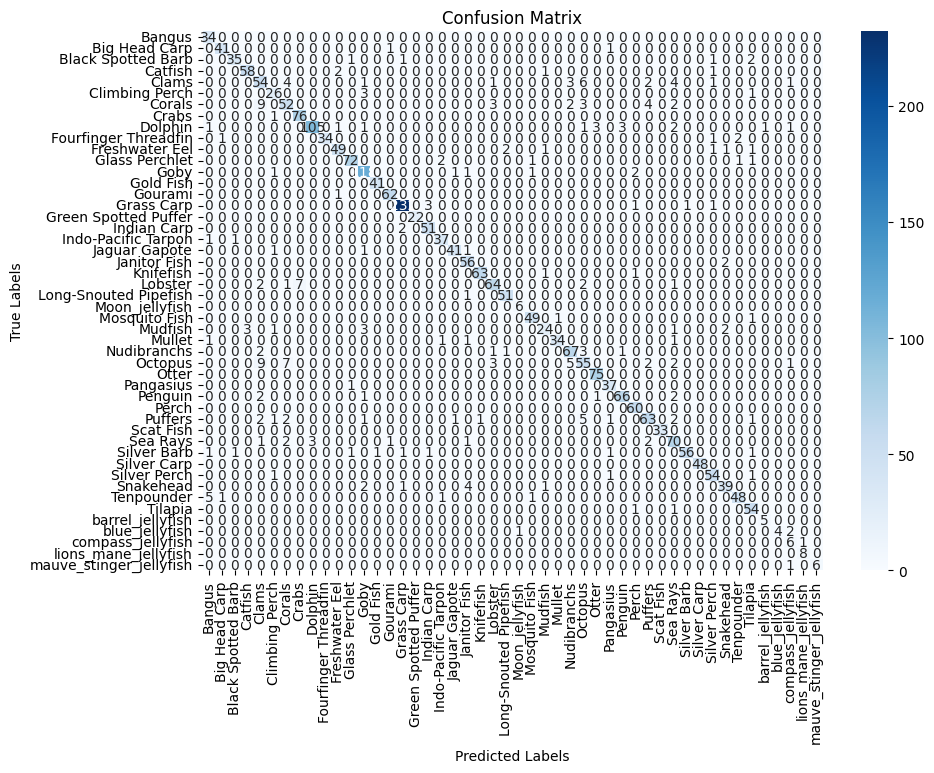

In [15]:
# Initialize variables to store true and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Calculate and display classification metrics
report = classification_report(true_labels, predicted_labels, target_names=test_dataset.classes)
print("Testing Performance:")
print(report)

# Create and plot confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Test

In [19]:
from google.colab import files
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [20]:
def predict_image(model, image_path, class_names):
    # Set model to evaluation mode
    model.eval()

    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Open and transform image
    img = Image.open(image_path).convert('RGB')
    img_transformed = transform(img)
    img_unsqueezed = img_transformed.unsqueeze(0)  # Add batch dimension

    # Move to device (CPU/GPU)
    device = next(model.parameters()).device
    img_unsqueezed = img_unsqueezed.to(device)

    # Get prediction
    with torch.no_grad():
        output = model(img_unsqueezed)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Get top 3 predictions
    top3_prob, top3_indices = torch.topk(probabilities, 3)

    # Display results
    plt.figure(figsize=(10, 4))

    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Input Image')
    plt.axis('off')

    # Show predictions
    plt.subplot(1, 2, 2)
    bars = plt.bar(range(3), top3_prob.cpu().numpy() * 100)
    plt.xticks(range(3), [class_names[idx] for idx in top3_indices.cpu().numpy()])
    plt.title('Top 3 Predictions')
    plt.xlabel('Class')
    plt.ylabel('Probability (%)')

    # Add percentage labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print predictions
    print("\nDetailed Predictions:")
    for i in range(3):
        print(f"{class_names[top3_indices[i]]}: {top3_prob[i]*100:.2f}%")

# Function to handle image upload and prediction
def upload_and_predict(model, class_names):
    print("Please upload an image...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\nMaking predictions for {filename}:")
        predict_image(model, filename, class_names)

In [21]:
# Load the trained model
model = create_model(num_classes=len(train_dataset.classes))
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

# Get class names from your dataset
class_names = train_dataset.classes

<ipython-input-21-ea80231a292c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Please upload an image...


Saving cropped-dancing-Chinstrap-penguin-787x650.png to cropped-dancing-Chinstrap-penguin-787x650.png

Making predictions for cropped-dancing-Chinstrap-penguin-787x650.png:


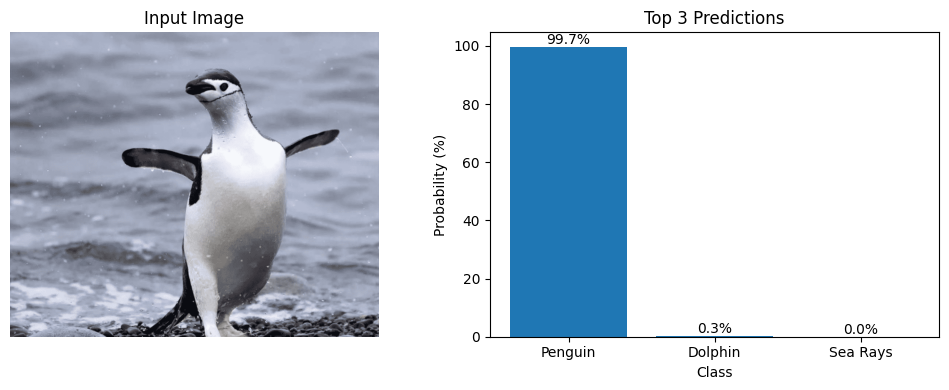


Detailed Predictions:
Penguin: 99.66%
Dolphin: 0.30%
Sea Rays: 0.01%


In [22]:
# Run prediction
upload_and_predict(model, class_names)

Please upload an image...


Saving thumb__1600_0_0_0_crop.jpg to thumb__1600_0_0_0_crop.jpg

Making predictions for thumb__1600_0_0_0_crop.jpg:


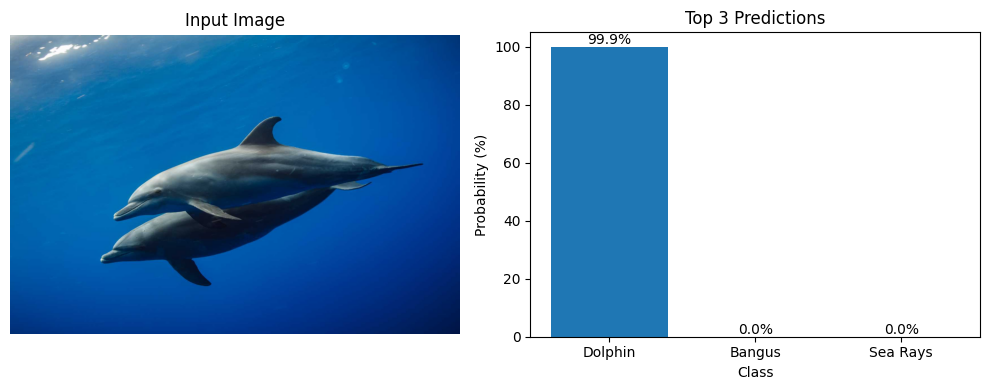


Detailed Predictions:
Dolphin: 99.95%
Bangus: 0.02%
Sea Rays: 0.01%


In [23]:
upload_and_predict(model, class_names)

Please upload an image...


Saving images.jpg to images.jpg

Making predictions for images.jpg:


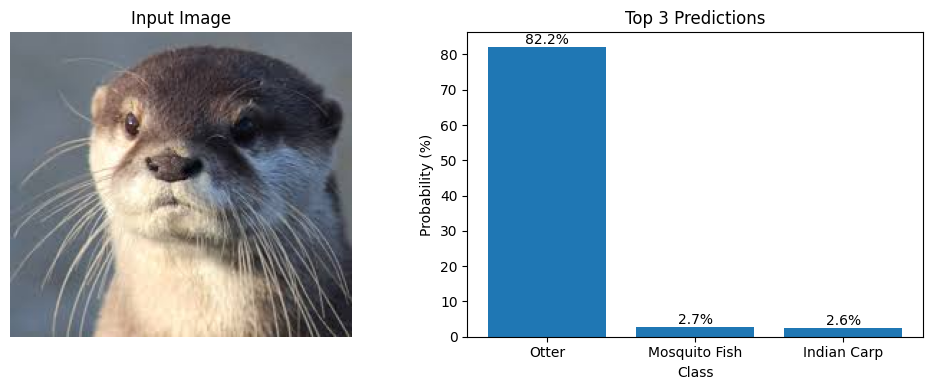


Detailed Predictions:
Otter: 82.16%
Mosquito Fish: 2.68%
Indian Carp: 2.58%


In [24]:
upload_and_predict(model, class_names)

Please upload an image...


Saving 5e54df09c9ae8.jpg to 5e54df09c9ae8.jpg

Making predictions for 5e54df09c9ae8.jpg:


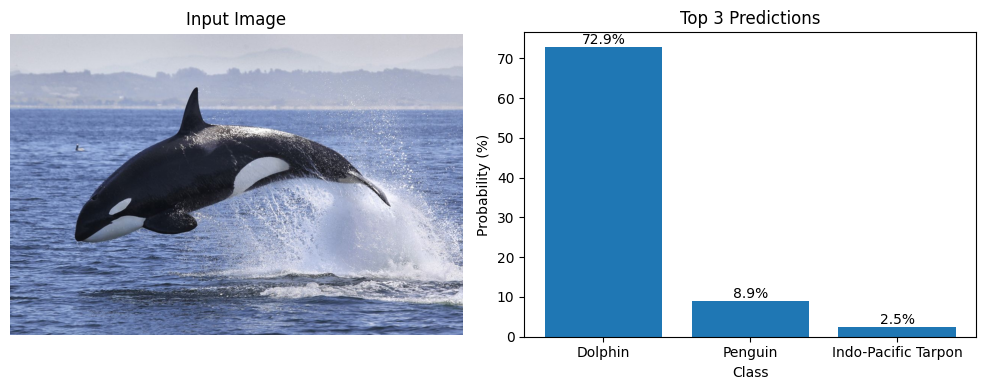


Detailed Predictions:
Dolphin: 72.93%
Penguin: 8.91%
Indo-Pacific Tarpon: 2.52%


In [25]:
upload_and_predict(model, class_names)